In [1]:
!pip install awswrangler
!pip install wntr
!pip install adtk

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [2]:
import wntr
# import tsnet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error

In [10]:
from adtk.data import validate_series
from adtk.detector import PersistAD
from adtk.visualization import plot
from adtk.transformer import DoubleRollingAggregate
from adtk.detector import ThresholdAD

In [8]:
def myDetectionFunc(a,b):
    return (a - b > 0.01)

In [40]:
from adtk.pipe import Pipeline
steps = [
    ("rolling", DoubleRollingAggregate(
            agg="median",
            window=1,
            center=True,
            diff=myDetectionFunc
        ),),
    ("threshold_ad", ThresholdAD(high=0.5))
]
pipeline = Pipeline(steps)

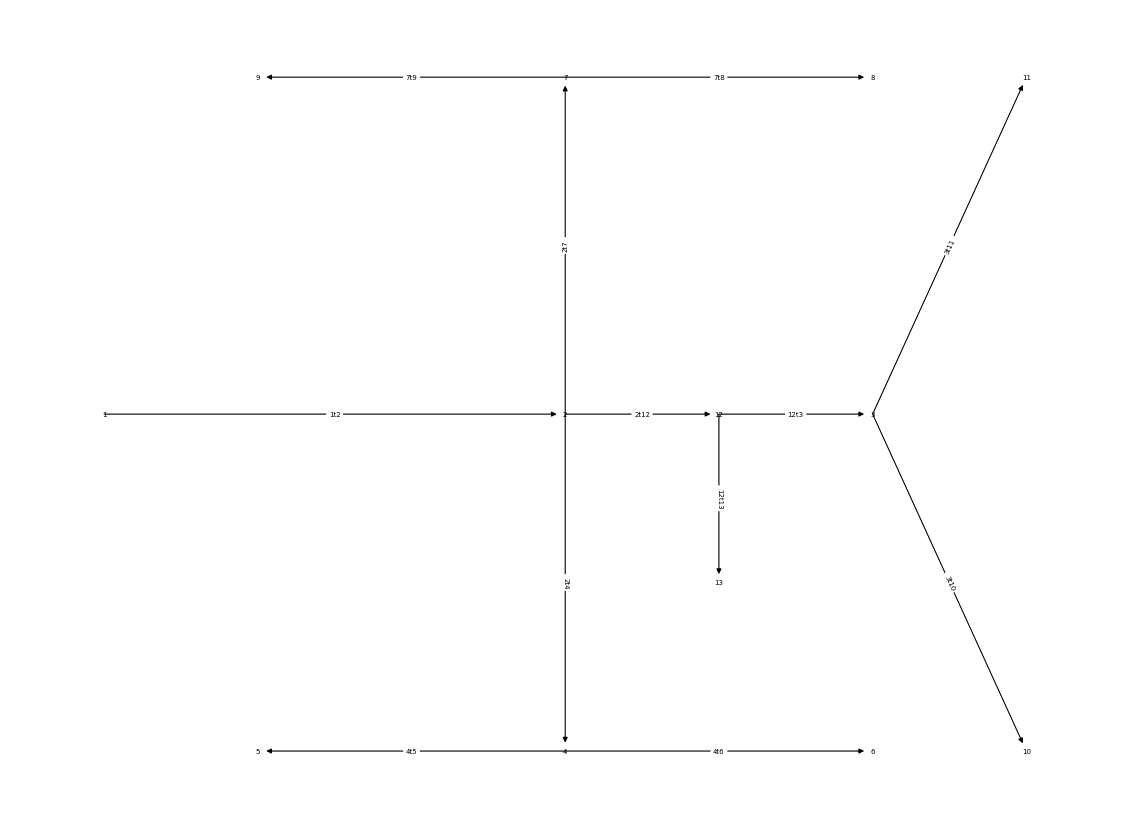

In [22]:
w = wntr.network.WaterNetworkModel('wnt3test2.inp')
Fig, Axarr = plt.subplots(1,1,figsize=(20,15))
Ax0 = Axarr
ax = wntr.graphics.plot_network(w, node_labels =True, node_size=0,link_labels =True,
node_cmap='k', directed=True, add_colorbar = False, ax=Ax0)

In [3]:
pressure = pd.read_csv('pressure.zip', compression='zip', header=0)

In [4]:
pressure = pressure[pressure['1t2']=='p0']

In [5]:
flow = pd.read_csv('flow.zip', compression='zip', header=0)
flow = flow[flow['p1t2']=='p0']

In [7]:
# import sagemaker
# sagemaker.Session().download_data("pressure.zip",'cactus-leakdata-s3','Hanoi-Data')

In [6]:
pressure_noleak = pressure.loc[pressure['status']==0, pressure.columns[:11]].copy(deep=True)
pressure_noleak = pressure_noleak.reset_index(drop=True)

In [7]:
pressure_leak = pressure.loc[pressure['status']==1, pressure.columns[:11]].copy(deep=True)
pressure_leak = pressure_leak.reset_index(drop=True)

In [8]:
flow_noleak = flow.loc[flow['status']==0, flow.columns[:10]].copy(deep=True)
flow_noleak = flow_noleak.reset_index(drop=True)
# flow_noleak = flow_noleak.pow(2)

In [9]:
flow_leak = flow.loc[flow['status']==1, flow.columns[:10]].copy(deep=True)
flow_leak = flow_leak.reset_index(drop=True)
# flow_leak =  flow_leak.pow(2)

In [10]:
df_results = pd.DataFrame()
pipes = [pipe for pipe in list(flow.columns[:10]) if not '1t' in pipe] 
for pipe in pipes:
    df = pd.DataFrame()
    start_node = pipe.split('t')[0]
    end_node = pipe.split('t')[1]
    df['pstart'] = pressure_noleak[start_node].copy()
    df['flow'] = flow_noleak[pipe].copy()
    df['pend'] = pressure_noleak[end_node].copy()
    
    df_results = pd.concat([df_results, df])

In [11]:
df_results_leak = pd.DataFrame()
pipes = [pipe for pipe in list(flow_leak.columns[:10]) if not '1t' in pipe] 
for pipe in pipes:
    df = pd.DataFrame()
    start_node = pipe.split('t')[0]
    end_node = pipe.split('t')[1]
    df['pstart'] = pressure_leak[start_node].copy()
    df['flow'] = flow_leak[pipe].copy()
    df['pend'] = pressure_leak[end_node].copy()
    
    df_results_leak = pd.concat([df_results_leak, df])

In [12]:
df_results

,pstart,flow,pend
0,20.576,28.000,17.801
1,20.576,28.000,17.801
2,20.576,28.000,17.801
3,20.593,27.982,17.829
4,20.593,27.982,17.829
...,...,...,...
377995,16.442,0.088,0.007
377996,16.442,0.088,0.007
377997,16.442,0.088,0.007
377998,16.456,0.088,0.007


In [15]:
X1 = df_results.loc[:, df_results.columns[0:2]]
y1 = np.asarray(df_results[df_results.columns[2]]).ravel()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.1, random_state=42, shuffle=True)
normalizer = StandardScaler()
normalizer.fit(X_train1.values)
X_train1_norm = normalizer.transform(X_train1.values)
X_test1_norm = normalizer.transform(X_test1.values)
regr = linear_model.LinearRegression()

scores = cross_val_score(regr, X_train1_norm, y_train1, cv=10)
print(scores.mean())
# Make predictions using the testing set
regr.fit(X_train1_norm, y_train1)
# y_pred = regr.predict(X_test1_norm)

X1_leak = df_results_leak.loc[:, df_results_leak.columns[0:2]]
y1_leak = np.asarray(df_results_leak[df_results_leak.columns[2]]).ravel()
# normalizer = StandardScaler()
# X1_norm = normalizer.fit_transform(X1.values)
X1_leak_norm = normalizer.transform(X1_leak.values)
# regr = linear_model.LinearRegression()
# scores = cross_val_score(regr, X1_norm, y1, cv=10)
# print(scores.mean())
# regr.fit(X1_norm, y1)
y_pred = regr.predict(X1_leak_norm)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y1_leak, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y1_leak, y_pred))

0.9017614539273391
Coefficients: 
 [7.762 3.246]
Mean squared error: 39.51
Coefficient of determination: 0.80


In [16]:
scores

array([0.901, 0.902, 0.902, 0.902, 0.902, 0.902, 0.902, 0.902, 0.902, 0.902])

In [17]:
# results = pd.DataFrame()
results = {}
pipes = [pipe for pipe in list(flow.columns[:10]) if not '1t' in pipe] 
for pipe in pipes:
    df = pd.DataFrame()
    start_node = pipe.split('t')[0]
    end_node = pipe.split('t')[1]
    df['pstart'] = pressure_noleak[start_node].copy()
    df['flow'] = flow_noleak[pipe].copy()
    df['pend'] = pressure_noleak[end_node].copy()
    
    results[pipe] = df

In [18]:
results_leak = {}
pipes = [pipe for pipe in list(flow_leak.columns[:10]) if not '1t' in pipe] 
for pipe in pipes:
    df = pd.DataFrame()
    start_node = pipe.split('t')[0]
    end_node = pipe.split('t')[1]
    df['pstart'] = pressure_leak[start_node].copy()
    df['flow'] = flow_leak[pipe].copy()
    df['pend'] = pressure_leak[end_node].copy()
    
    results_leak[pipe] = df

In [16]:
results['3t10']

,pstart,flow,pend
0,17.801,10.00,16.311
1,17.801,10.00,16.311
2,17.801,10.00,16.311
3,17.829,9.99,16.342
4,17.829,9.99,16.342
...,...,...,...
377995,27.913,6.01,27.339
377996,27.913,6.01,27.339
377997,27.913,6.01,27.339
377998,27.935,6.00,27.363


In [17]:
results_leak['3t10']

,pstart,flow,pend
0,27.900,6.00,27.327
1,27.900,6.00,27.327
2,27.922,5.99,27.351
3,27.922,5.99,27.351
4,27.922,5.99,27.351
...,...,...,...
377995,35.476,2.01,35.409
377996,35.476,2.01,35.409
377997,35.491,2.00,35.425
377998,35.491,2.00,35.425


In [21]:
X1_2t3 = results['2t3'].loc[:,results['2t3'].columns[0:2]]
y1_2t3 = np.asarray(results['2t3'][results['2t3'].columns[2]]).ravel()
normalizer = StandardScaler()
X1_2t3_norm = normalizer.fit_transform(X1_2t3.values)
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X1_2t3_norm, y1_2t3, cv=10)
print(scores.mean())
X1_2t3_leak = results_leak['2t3'].loc[:,results_leak['2t3'].columns[0:2]]
y1_2t3_leak = np.asarray(results_leak['2t3'][results_leak['2t3'].columns[2]]).ravel()
# normalizer = StandardScaler()
X1_2t3_leak_norm = normalizer.transform(X1_2t3_leak.values)
# Make predictions using the testing set
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X1_2t3_norm, y1_2t3)
y_pred_leak = regr.predict(X1_2t3_leak_norm)
# The coefficients
print('Coefficients: \n', regr.coef_)
print('intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y1_2t3_leak, y_pred_leak))
print('Mean absolute error: %.2f'
      % mean_absolute_error(y1_2t3_leak, y_pred_leak))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y1_2t3_leak, y_pred_leak))

0.9999999597702789
Coefficients: 
 [2.981 0.052]
intercept: 
 23.07335739153438
Mean squared error: 0.00
Mean absolute error: 0.01
Coefficient of determination: 1.00


In [27]:
X1_3t10 = results['3t10'].loc[:, results['3t10'].columns[0:2]]
y1_3t10 = np.asarray(results['3t10'][results['3t10'].columns[2]]).ravel()
normalizer = StandardScaler()
X1_3t10_norm = normalizer.fit_transform(X1_3t10.values)
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X1_3t10_norm, y1_3t10, cv=10)
print(scores.mean())
X1_3t10_leak = results_leak['3t10'].loc[:,results_leak['3t10'].columns[0:2]]
y1_3t10_leak = np.asarray(results_leak['3t10'][results_leak['3t10'].columns[2]]).ravel()
# normalizer = StandardScaler()
X1_3t10_leak_norm = normalizer.transform(X1_3t10_leak.values)
# Train the model using the training sets
regr.fit(X1_3t10_norm, y1_3t10)
y_pred_leak = regr.predict(X1_3t10_leak_norm)
# The coefficients
print('Coefficients: \n', regr.coef_)
print('intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y1_3t10_leak, y_pred_leak))
print('Mean absolute error: %.2f'
      % mean_absolute_error(y1_2t3_leak, y_pred_leak))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y1_3t10_leak, y_pred_leak))

0.9999999819302726
Coefficients: 
 [3.391 0.196]
intercept: 
 22.074791923280415
Mean squared error: 0.00
Mean absolute error: 0.28
Coefficient of determination: 1.00


In [23]:
X1_4t5 = results['4t5'].loc[:, results['4t5'].columns[0:2]]
y1_4t5 = np.asarray(results['4t5'][results['4t5'].columns[2]]).ravel()
normalizer = StandardScaler()
X1_4t5_norm = normalizer.fit_transform(X1_4t5.values)
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X1_4t5_norm, y1_4t5, cv=10)
print(scores.mean())
X1_4t5_leak = results_leak['4t5'].loc[:,results_leak['4t5'].columns[0:2]]
y1_4t5_leak = np.asarray(results_leak['4t5'][results_leak['4t5'].columns[2]]).ravel()
# normalizer = StandardScaler()
X1_4t5_leak_norm = normalizer.transform(X1_4t5_leak.values)
# Train the model using the training sets
regr.fit(X1_4t5_norm, y1_4t5)
y_pred_leak = regr.predict(X1_4t5_leak_norm)
# The coefficients
print('Coefficients: \n', regr.coef_)
print('intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y1_4t5_leak, y_pred_leak))
print('Mean absolute error: %.2f'
      % mean_absolute_error(y1_4t5_leak, y_pred_leak))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y1_4t5_leak, y_pred_leak))

0.817347794225021
Coefficients: 
 [ 0.002 -0.001]
intercept: 
 0.005687222222222221
Mean squared error: 0.00
Mean absolute error: 0.00
Coefficient of determination: 0.13


In [25]:
results_pipes

{'2t3': {'cvscore': 0.9999999597702789,
  'regcoef': array([2.981, 0.052]),
  'regintr': 23.07335739153438,
  'mse': 0.0001762945700044308,
  'mae': 0.01255607453574703,
  'mdae': 0.012698946664549737,
  'msle': 1.5760885043498583e-07,
  'cod': 0.9999632981485569,
  'mse_noleakset': 3.4692550756234147e-07,
  'mae_noleakset': 0.000492695658534125,
  'mdae_noleakset': 0.00046552032344138183,
  'msle_noleakset': 6.369656475394888e-10,
  'r2_noleakset': 0.9999999596899347},
 '2t4': {'cvscore': 0.9999999353115859,
  'regcoef': array([1.757e+00, 6.954e-04]),
  'regintr': 13.536649253968246,
  'mse': 1.284624765028095e-07,
  'mae': 0.00025594086329667104,
  'mdae': 0.0001946880253171912,
  'msle': 3.3026924938880204e-10,
  'cod': 0.9999999264205054,
  'mse_noleakset': 1.9997386883867142e-07,
  'mae_noleakset': 0.00039975078931579674,
  'mdae_noleakset': 0.0003678314050450382,
  'msle_noleakset': 1.0395240424683578e-09,
  'r2_noleakset': 0.9999999354552902},
 '2t7': {'cvscore': 0.9999999352782

In [26]:
results_leak

{'2t3':         pstart    flow    pend
 0       26.634  20.825  27.900
 1       26.634  20.825  27.900
 2       26.647  20.807  27.922
 3       26.647  20.807  27.922
 4       26.647  20.807  27.922
 ...        ...     ...     ...
 226795  31.194  13.618  35.474
 226796  31.194  13.618  35.474
 226797  31.204  13.600  35.490
 226798  31.204  13.600  35.490
 226799  31.204  13.600  35.490
 
 [226800 rows x 3 columns],
 '2t4':         pstart   flow    pend
 0       26.634  0.182  16.433
 1       26.634  0.182  16.433
 2       26.647  0.182  16.446
 3       26.647  0.182  16.446
 4       26.647  0.182  16.446
 ...        ...    ...     ...
 226795  31.194  0.200  20.993
 226796  31.194  0.200  20.993
 226797  31.204  0.200  21.003
 226798  31.204  0.200  21.003
 226799  31.204  0.200  21.003
 
 [226800 rows x 3 columns],
 '2t7':         pstart   flow    pend
 0       26.634  0.176  16.433
 1       26.634  0.176  16.433
 2       26.647  0.176  16.446
 3       26.647  0.176  16.446
 4      

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
# Create linear regression object


In [36]:
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
y1_2t3_leak

array([27.9  , 27.9  , 27.922, ..., 35.491, 35.491, 35.491])

Coefficients: 
 [2.981 0.052]
intercept: 
 23.07335739153438
Mean squared error: 0.00
Coefficient of determination: 1.00


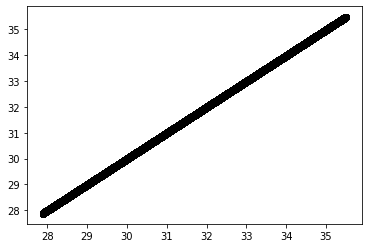

In [44]:
plt.scatter(y1_2t3_leak, y_pred_leak,  color='black')

Coefficients: 
 [ 5.802 -1.456]
Mean squared error: 3.99
Coefficient of determination: 0.86


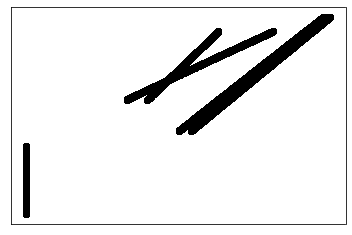

In [42]:
# Make predictions using the testing set
y_pred = regr.predict(X_test1_norm)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test1, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test1, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test1,  color='black')
# plt.plot(X2_test['pend'], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [53]:
# Make predictions using the testing set
y_pred_leak = regr.predict(X1_leak_norm)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y1_leak, y_pred_leak))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y1_leak, y_pred_leak))

Coefficients: 
 [ 5.802 -1.456]
Mean squared error: 16.46
Coefficient of determination: 0.53


In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X1_norm, y1, cv=10)

In [49]:
scores.mean()

-1.8259264811371818

In [48]:
pressure_test1 = pd.read_csv('pressure_test1.zip', compression='zip', header=0) 
pressure_test4 = pd.read_csv('pressure_test4.zip', compression='zip', header=0)

In [30]:
pressure_test4[3299:3600]

,2,3,4,5,6,7,8,9,10,11,...,2t3,2t7,7t9,3t10,2t4,7t8,3t11,4t5,4t6,status
3299,30.567,34.425,20.366,0.011,0.017,20.366,0.010,0.025,34.305,34.340,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
3300,30.551,34.414,20.350,0.011,0.017,20.350,0.010,0.025,34.295,34.330,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
3301,30.551,34.414,20.350,0.011,0.017,20.350,0.010,0.025,34.295,34.330,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
3302,30.551,34.414,20.350,0.011,0.017,20.350,0.010,0.025,34.295,34.330,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
3303,30.551,34.414,20.350,0.011,0.017,20.350,0.010,0.025,34.295,34.330,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,31.187,35.466,20.986,0.013,0.020,20.986,0.012,0.030,35.399,35.420,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
3596,31.187,35.466,20.986,0.013,0.020,20.986,0.012,0.030,35.399,35.420,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
3597,31.197,35.481,20.996,0.013,0.020,20.995,0.012,0.031,35.415,35.436,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1
3598,31.197,35.481,20.996,0.013,0.020,20.995,0.012,0.031,35.415,35.436,...,p4,p8,p1,p0,p0,p0,p0,p0,p0,1


In [33]:
import time
now_in_s = int(time.time())
# pressure_test4['time']  = now_in_s + (pressure3['time'] * 1e6).round(0).astype(int)
# pressure_test4.set_index('time',inplace=True)
pressure_test4.index =  pd.to_datetime(now_in_s + pressure_test4.index , unit='s')

In [34]:
pressure_test4[:3600]['7']

2021-06-16 11:34:17    16.456
2021-06-16 11:34:18    16.456
2021-06-16 11:34:19    16.456
2021-06-16 11:34:20    16.469
2021-06-16 11:34:21    16.469
                        ...  
2021-06-16 12:04:13    20.986
2021-06-16 12:04:14    20.986
2021-06-16 12:04:15    20.995
2021-06-16 12:04:16    20.995
2021-06-16 12:04:17    20.995
Name: 7, Length: 1801, dtype: float64

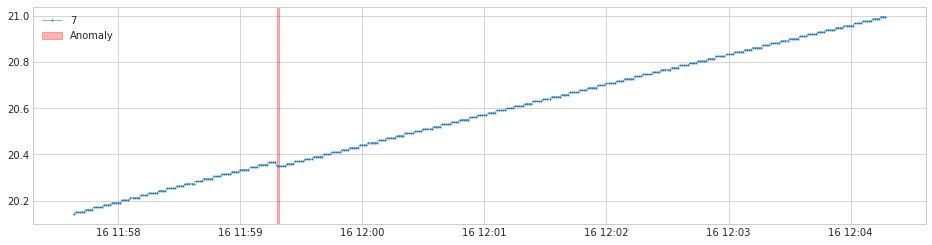

In [45]:
s = validate_series(pressure_test4[3200:3600]['7'])
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

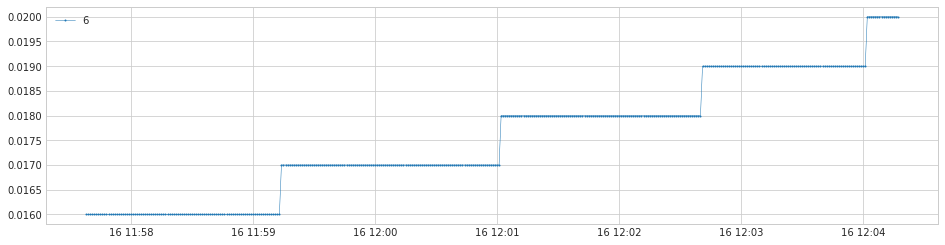

In [46]:
s = validate_series(pressure_test4[3200:3600]['6'])
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

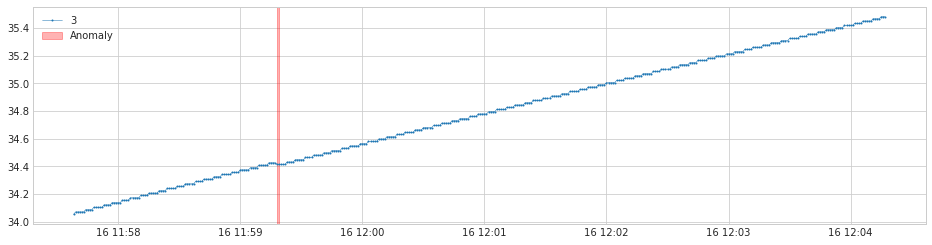

In [47]:
s = validate_series(pressure_test4[3200:3600]['3'])
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

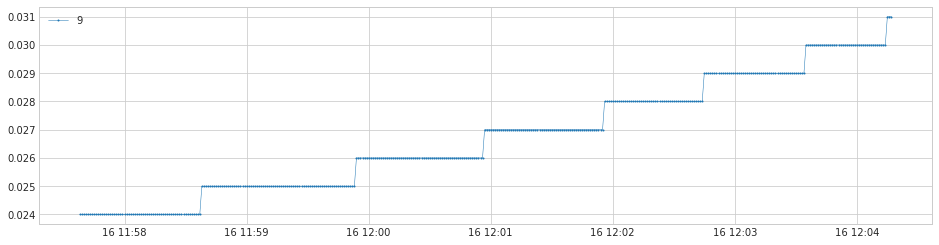

In [48]:
s = validate_series(pressure_test4[3200:3600]['9'])
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');